## Correct 1D LCT Including Units and Wavelength

In [1]:
import numpy as np
import time as tm
import math
#import os 
#import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# import scipy.ndimage
# import scipy.ndimage as ip
# from srwlib import *
# from LCTlib import *
import LCTlib as lct

import srwlib
from srwlib import srwl
from srwlib import *

# plt.style.available
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
# plt.style.use('Solarize_Light2')
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}
hfontMed = {'fontname':'Latin Modern Roman', 'size' : 15}

***
##### Construct 2D complex Gaussian

In [2]:
# phLambda = 0.8e-6               # wavelength [m]; 0.8e-6 m = 800 nm or wavelength of Ti-Sapphire laser
# k = 2 * np.pi / phLambda        # wave number
# sigmax_gsn_init = 0.65e-3       # RMS beam size for initial Gsn [m] (w0/2)
# sigmay_gsn_init = 0.65e-3       # RMS beam size for initial Gsn [m] (w0/2)
# print('initial beam size: %g [mm]' %(sigmax_gsn_init*1e3))
# sigma_no_gsn_init = 12          # no. of sigmas for initial Gsn range
# dist_waist = 0                  # distance from waist [m] (z in the notes)

# z_R = 4 * np.pi * sigmax_gsn_init**2 / phLambda    # Rayleigh range 
# q_gsn_init = dist_waist + 1j * z_R                 # complex beam parameter for initial Gsn
 
# # construct x value array for initial Gsn    
# ranx_gsn_init = sigma_no_gsn_init * sigmax_gsn_init   # mesh range for initial Gsn
# nx_gsn_init = 1e3                                     # no. of mesh points for initial Gsn
# xvals_gsn_init = np.linspace(-ranx_gsn_init, ranx_gsn_init, int(nx_gsn_init))

# # construct initial complex Gsn field
# E_field_gsn_init = (1 / np.sqrt(np.abs(q_gsn_init))) * np.exp(-1j * k * np.square(xvals_gsn_init) / 2 / q_gsn_init)
# int_gsn_init = np.square(np.abs(E_field_gsn_init))

In [3]:
def createGsnSrcSRW02(sigx, sigy, num_sig, dist_waist, pulseE, poltype, nx = 400, ny = 400, phE=10e3, mx = 0, my = 0):
    """
    This function calculates a Gsn wavefront with waist at zero meters
    and allows calculation at any longitudinal point via dist_waist.
    Args:
        sigx: horizontal beam size at waist [m]
        sigy: vertical beam size at waist [m]
        num_sig: no. of sigmas for Gsn range
        dist_waist: distance of Gsn from waist [m]
        pulseE: energy per pulse [J]
        poltype: polarization type (0=linear horizontal, 1=linear vertical, 2=linear 45 deg, 3=linear 135 deg, 4=circular right, 5=circular left, 6=total)
        nx = no. of horizontal mesh points
        ny = no. of vertical mesh points
        phE: photon energy [eV]
        mx = horizontal Hermite mode
        my = vertical Hermite mode

    Returns:
        wfr
    """

    constConvRad = 1.23984186e-06/(4*3.1415926536)  ##conversion from energy to 1/wavelength
    rmsAngDiv_x = constConvRad/(phE*sigx)             ##RMS angular divergence [rad]
    rmsAngDiv_y = constConvRad/(phE*sigy)
    sigrL_x = math.sqrt(sigx**2+(dist_waist*rmsAngDiv_x)**2)  ##required RMS size to produce requested RMS beam size after propagation by propLen
    sigrL_y = math.sqrt(sigy**2+(dist_waist*rmsAngDiv_y)**2)
    # sigrL=math.sqrt(sigrW**2+(propLen*rmsAngDiv)**2)

    #***********Gaussian Beam Source
    GsnBm = SRWLGsnBm() #Gaussian Beam structure (just parameters)
    GsnBm.x = 0 #Transverse Positions of Gaussian Beam Center at Waist [m]
    GsnBm.y = 0
    GsnBm.z = 0.0 # Longitudinal Position of Waist [m]
    GsnBm.xp = 0 # Average Angles of Gaussian Beam at Waist [rad]
    GsnBm.yp = 0
    GsnBm.avgPhotEn = phE # Photon Energy [eV]
    GsnBm.pulseEn = pulseE # Energy per Pulse [J] - to be corrected
    GsnBm.repRate = 1 # Rep. Rate [Hz] - to be corrected
    GsnBm.polar = poltype # 1- linear horizontal?
    GsnBm.sigX = sigx # Horiz. RMS size at Waist [m]
    GsnBm.sigY = sigy # Vert. RMS size at Waist [m]

    GsnBm.sigT = 10e-15 #Pulse duration [s] (not used?)
    GsnBm.mx = mx #Transverse Gauss-Hermite Mode Orders
    GsnBm.my = my

    #***********Initial Wavefront
    # create mesh
    wfr = SRWLWfr() #Initial Electric Field Wavefront
    wfr.allocate(1, nx, ny) #Numbers of points vs Photon Energy (1), Horizontal and Vertical Positions (dummy)
    wfr.mesh.zStart = dist_waist #Longitudinal Position [m] at which initial Electric Field has to be calculated, i.e. the position of the first optical element
    wfr.mesh.eStart = GsnBm.avgPhotEn #Initial Photon Energy [eV]
    wfr.mesh.eFin = GsnBm.avgPhotEn #Final Photon Energy [eV]

    wfr.unitElFld = 1 # Electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)

    distSrc = wfr.mesh.zStart - GsnBm.z
    # Horizontal and Vertical Position Range for the Initial Wavefront calculation
    # can be used to simulate the First Aperture (of M1)
    # firstHorAp = 8.*rmsAngDiv*distSrc #[m]
    # xAp = 8.*sigrL
    # yAp = xAp #[m]
    
    xAp = num_sig * sigrL_x
    yAp = num_sig * sigrL_y

    wfr.mesh.xStart = -xAp #Initial Horizontal Position [m]
    wfr.mesh.xFin = xAp #Final Horizontal Position [m]
    wfr.mesh.yStart = -yAp #Initial Vertical Position [m]
    wfr.mesh.yFin = yAp #Final Vertical Position [m]

    # sampFactNxNyForProp = sampFact #sampling factor for adjusting nx, ny (effective if > 0)
    arPrecPar = [0] # sampFact set to zero to allow manual setting of mesh size via wfr.allocate()

    srwl.CalcElecFieldGaussian(wfr, GsnBm, arPrecPar)

    ##Beamline to propagate to waist

    # optDriftW=SRWLOptD(propLen)
    # propagParDrift = [0, 0, 1., 0, 0, 1.1, 1.2, 1.1, 1.2, 0, 0, 0]
    # optBLW = SRWLOptC([optDriftW],[propagParDrift])
    # #wfrW=deepcopy(wfr)
    # srwl.PropagElecField(wfr, optBLW)

    return wfr

def calc_int_from_wfr(_wfr, _pol=6, _int_type=0, _det=None, _fname='', _pr=True):
# def calc_int_from_wfr(self, _wfr, _pol=6, _int_type=0, _det=None, _fname='', _pr=True):
        """Calculates intensity from electric field and saving it to a file
        :param _wfr: electric field wavefront (instance of SRWLWfr)
        :param _pol: polarization component to extract: 
            0- Linear Horizontal; 
            1- Linear Vertical; 
            2- Linear 45 degrees; 
            3- Linear 135 degrees; 
            4- Circular Right; 
            5- Circular Left; 
            6- Total
        :param _int_type: "type" of a characteristic to be extracted:
           -1- No Intensity / Electric Field components extraction is necessary (only Wavefront will be calculated)
            0- "Single-Electron" Intensity; 
            1- "Multi-Electron" Intensity; 
            2- "Single-Electron" Flux; 
            3- "Multi-Electron" Flux; 
            4- "Single-Electron" Radiation Phase; 
            5- Re(E): Real part of Single-Electron Electric Field;
            6- Im(E): Imaginary part of Single-Electron Electric Field;
            7- "Single-Electron" Intensity, integrated over Time or Photon Energy (i.e. Fluence);
        :param _det: detector (instance of SRWLDet)
        :param _fname: name of file to save the resulting data to (for the moment, in ASCII format)
        :param _pr: switch specifying if printing tracing the execution should be done or not
        :return: 1D array with (C-aligned) resulting intensity data
        """

        if _pr:
            print('Extracting intensity and saving it to a file ... ', end='')
            t0 = time.time();
            
        sNumTypeInt = 'f'
        if(_int_type == 4): sNumTypeInt = 'd' #Phase? - if asking for phase, set array to double type

        resMeshI = deepcopy(_wfr.mesh)

        depType = resMeshI.get_dep_type()
        if(depType < 0): Exception('Incorrect numbers of points in the mesh structure')
        
        arI = srwlib.array(sNumTypeInt, [0]*resMeshI.ne*resMeshI.nx*resMeshI.ny)
        srwl.CalcIntFromElecField(arI, _wfr, _pol, _int_type, depType, resMeshI.eStart, resMeshI.xStart, resMeshI.yStart)

        if(_det is not None):
            resStkDet = _det.treat_int(arI, resMeshI)
            arI = resStkDet.arS
            resMeshI = resStkDet.mesh

        if(len(_fname) > 0): srwl_uti_save_intens_ascii(arI, resMeshI, _fname, 0, ['Photon Energy', 'Horizontal Position', 'Vertical Position', ''], _arUnits=['eV', 'm', 'm', 'ph/s/.1%bw/mm^2'])
        if _pr: print('completed (lasted', round(time.time() - t0, 2), 's)')

        return arI, resMeshI

In [4]:
# define Gsn wavefront parameters
dist_waist = 0     # distance to waist [m]
sigx = 1e-3        # horizontal RMS beam size (intensity) [m]
sigy = 1e-3        # vertical RMS beam size (intensity) [m]
num_sig = 24        # no. of sigmas for Gsn range
nx_init = 100      # no. of horizontal mesh points
ny_init = 100      # no. of vertical mesh points
pulseE = 0.001     # pulse energy [eV]
poltype = 1        # polarization type
phE = 0.124        # photon energy [eV] 
mx = 0             # horizontal Hermite mode
my = 0             # vertical Hermite mode

hc_ev_um = 1.23984198   # hc [eV*um]
phLambda = hc_ev_um / phE * 1e-6 # wavelength corresponding to phE in meters
print("Wavelength corresponding to %g keV: %g microns" %(phE * 1e-3, phLambda / 1e-6))

Wavelength corresponding to 0.000124 keV: 9.99873 microns


In [5]:
# create initial Gsn wavefront
wfr0 = createGsnSrcSRW02(sigx, sigy, num_sig, dist_waist, pulseE, poltype, nx_init, ny_init, phE, mx, my)

In [6]:
# calculate phase, E field, and intensity from initial Gsn wavefront
int0, int0_mesh = calc_int_from_wfr(wfr0, _pol=0, _int_type=0, _det=None, _fname='', _pr=True)
phase0, phase0_mesh = calc_int_from_wfr(wfr0, _pol=0, _int_type=4, _det=None, _fname='', _pr=True)
re0, re0_mesh = calc_int_from_wfr(wfr0, _pol=0, _int_type=5, _det=None, _fname='', _pr=True)
im0, im0_mesh = calc_int_from_wfr(wfr0, _pol=0, _int_type=6, _det=None, _fname='', _pr=True)

Extracting intensity and saving it to a file ... completed (lasted 0.0 s)
Extracting intensity and saving it to a file ... completed (lasted 0.0 s)
Extracting intensity and saving it to a file ... completed (lasted 0.0 s)
Extracting intensity and saving it to a file ... completed (lasted 0.0 s)


In [7]:
# reshape into 2D Gsn phase, E field, and intensity arrays
int0_2d = np.array(int0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
phase0_2d = np.array(phase0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
re0_2d = np.array(re0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
im0_2d = np.array(im0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
print('Size of initial mesh (coordinate):',np.shape(int0_2d))

Size of initial mesh (coordinate): (100, 100)


In [8]:
# create corresponding x and y arrays for 2D Gsn phase, E field, and intensity arrays
xvals_gsn_init=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvals_gsn_init=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

In [9]:
# calculate E field total from Re(E) and Im(E)
E_field_gsn_init = re0_2d + np.multiply(im0_2d, 1j)

Text(0.5, 1.0, 'Initial Wavefront Intensity')

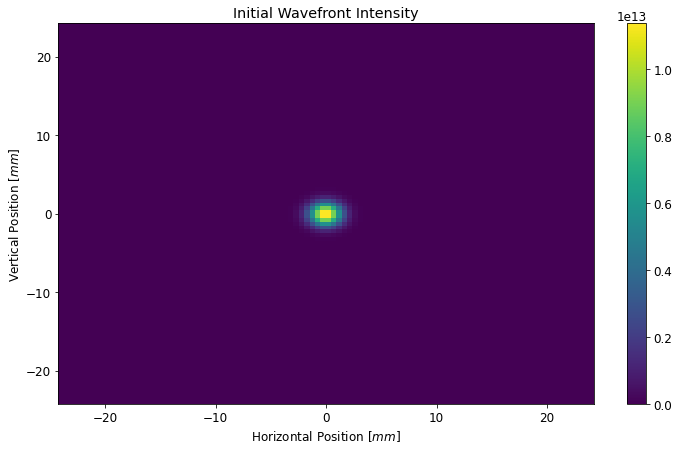

In [23]:
# plot initial intensity
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Intensity')

Text(0.5, 1.0, 'Initial Wavefront Re(E)')

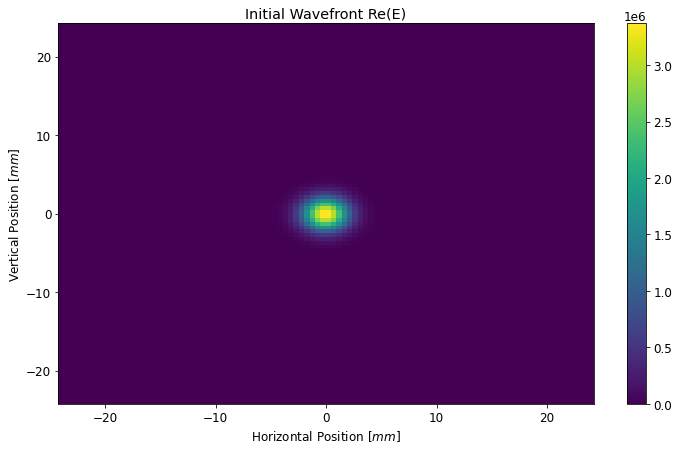

In [25]:
# plot initial Re(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), re0_2d, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Re(E)')

Text(0.5, 1.0, 'Initial Wavefront Im(E)')

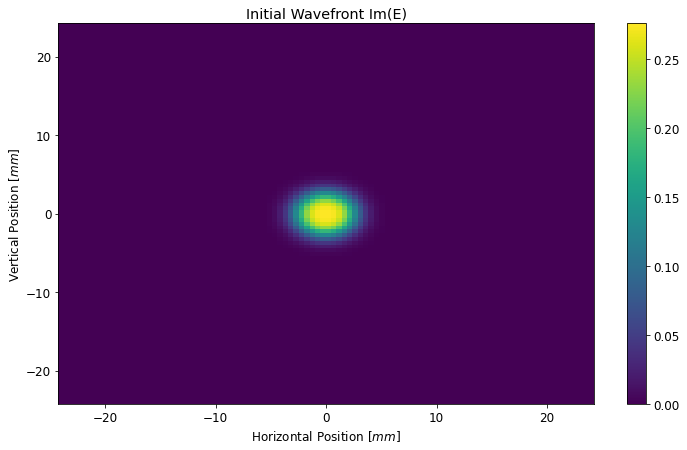

In [26]:
# plot initial Im(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), im0_2d, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Im(E)')

***
##### Apply LCT to 2D complex Gaussian

In [13]:
# define matrix for LCT transformation

l_scale = 1                     # scale length in LCT

# lct_mat = lct.rotation_22(360 / 3 * (np.pi / 180.))

L = 10    # drift length [m]


# lct_mat = np.array([[ 1,  L  ],
#                      [ 0, 1 ]])
lct_mat = np.array([[ 1,  L*phLambda  ],
                    [ 0, 1 ]])
# lct_mat = np.array([[ 1,  L*phLambda/(l_scale**2)  ],
#                      [ 0, 1 ]])
print(lct_mat[0,1])

9.998725645161289e-05


In [14]:
dx = (xvals_gsn_init[1] - xvals_gsn_init[0])             # horizontal spacing of input signal [m]
dy = (yvals_gsn_init[1] - yvals_gsn_init[0])             # vertical spacing of input signal [m]
# xv = lct_abscissae(nx_init, dX, ishift = False)      # x values array of input signal
# du = dx/l_scale
print("dx = %4.3g" % dx)
print("dy = %4.3g" % dy)
# print("du = %4.3g" % du)

dx = 0.000485
dy = 0.000485


In [15]:
in_signal = dx, dy, E_field_gsn_init     # signal format for input into apply_lct()

In [16]:
t0 = tm.time()
dX_out, dY_out, out_signal_2d = lct.apply_lct_2d_sep(lct_mat, lct_mat, in_signal)
t1 = tm.time()
print("LCT runtime: %4.3g seconds" % ((t1 - t0)))  

LCT runtime: 0.127 seconds


In [17]:
# calculate x and y mesh arrays for transformed wavefront
hx = dX_out 
hy = dY_out 
sig_arr = out_signal_2d
ny, nx = np.shape(sig_arr)
local_xv = lct.lct_abscissae(nx, hx)
local_yv = lct.lct_abscissae(ny, hy)

In [18]:
# calculate propagated intensity distribution from complex LCT output
int_final = np.square(np.abs(sig_arr))

propagated mesh: (101, 101)


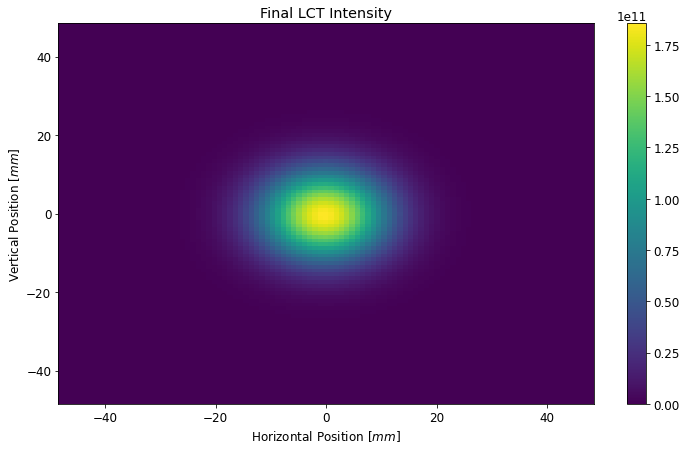

In [19]:
# plot final intensity
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

# plt.pcolormesh(local_xv*1e6, local_yv*1e6, np.square(np.abs(sig_arr)), cmap=plt.cm.viridis, shading='auto')
plt.pcolormesh(local_xv*1e3, local_yv*1e3, int_final, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-5e6,5e6)
# ax.set_xlim(-5e6,5e6)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Final LCT Intensity')
print('propagated mesh:', np.shape(sig_arr))

propagated mesh: (101, 101)


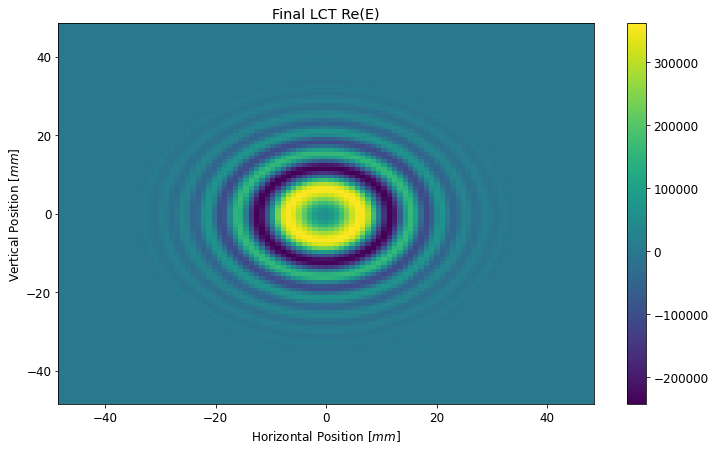

In [20]:
# plot final Re(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

# plt.pcolormesh(local_xv*1e6, local_yv*1e6, np.square(np.abs(sig_arr)), cmap=plt.cm.viridis, shading='auto')
plt.pcolormesh(local_xv*1e3, local_yv*1e3, np.real(sig_arr), cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-5e6,5e6)
# ax.set_xlim(-5e6,5e6)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Final LCT Re(E)')
print('propagated mesh:', np.shape(sig_arr))

propagated mesh: (101, 101)


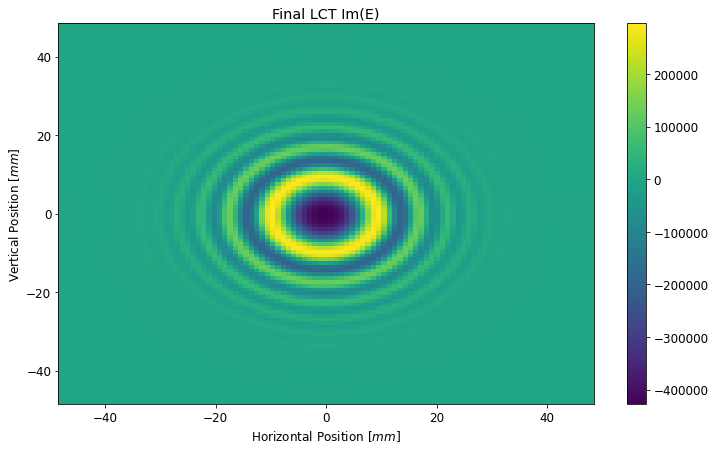

In [21]:
# plot final Im(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

# plt.pcolormesh(local_xv*1e6, local_yv*1e6, np.square(np.abs(sig_arr)), cmap=plt.cm.viridis, shading='auto')
plt.pcolormesh(local_xv*1e3, local_yv*1e3, np.imag(sig_arr), cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-5e6,5e6)
# ax.set_xlim(-5e6,5e6)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Final LCT Im(E)')
print('propagated mesh:', np.shape(sig_arr))

In [22]:
in_signal = du, E_field_gsn_init     # signal format for input into apply_lct()

NameError: name 'du' is not defined

In [ ]:
t0 = tm.time()
out_signal = lct.apply_lct(lct_mat, in_signal)
t1 = tm.time()
print("LCT runtime: %4.3g seconds" % ((t1 - t0)))  

In [ ]:
hu_out, sig_arr_out = out_signal   # extract horizontal spacing [m] and E field data respectively from output signal
hx_out = hu_out*l_scale
nx_out = np.size(sig_arr_out)
ranx_out = nx_out * hx_out
# rany_out = ny_out * hy_out
print('prop. hor. range: %g [m]' %(ranx_out)) 

# dX_out = ranx_out / (nx_out - 1)       # horizontal spacing of output signal [m]


xvals_out = lct.lct_abscissae(nx_out, hx_out, ishift = False)

print(hx_out)
print('input mesh: %e points' %(nx_gsn_init))
print('output mesh: %e points' %(nx_out))

In [ ]:
np.shape(xvals_out)

In [ ]:
# calculate total field magnitude and intensity
E_field_tot_out = np.abs(sig_arr_out)
int_out = np.square(E_field_tot_out)

In [ ]:
# plot output intensity
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(xvals_out*1e6, int_out,'r-', lw = 1)
ax.set_xlim(-2e4, 2e4)
# ax.set_ylim(-1e4, 1e4)
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'$E_{field}$ [$1/m$]')
ax.set_title(r'output intensity')
fig.show()

In [ ]:
# plot output Re(E)
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(xvals_out*1e6, np.real(sig_arr_out),'r-', lw = 1)
ax.plot(xvals_out*1e6, np.imag(sig_arr_out),'b-', lw = 1)
ax.set_xlim(-2e4, 2e4)
# ax.set_ylim(-1e4, 1e4)
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'$E_{field}$ [$1/\sqrt{m}$ ]')
ax.set_title(r'output Re(E) and Im(E)')
fig.show()

In [ ]:
#xvals_out[nx_out/2]

In [ ]:
# Construct final Gaussian via creation and plot

q_gsn_final = -L + q_gsn_init 
E_field_gsn_final = (1 / np.sqrt(np.abs(q_gsn_final))) * np.exp(-1j * k * np.square(xvals_out) / 2 / q_gsn_final)
#multiply by phase
#tune=.08
#tune = 0.42

midpt=np.ceil(nx_out/2).astype(int)
xvals_out[midpt]
pfact = E_field_gsn_final[midpt]/sig_arr_out[midpt]


E_field_gsn_final /= pfact 


# plot output Re(E)
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(xvals_out*1e6, np.real(E_field_gsn_final),'r-', lw = 1)
#ax.plot(xvals_out*1e6, np.imag(E_field_gsn_final),'-', lw = 1)
ax.plot(xvals_out*1e6, np.real(sig_arr_out),'-', lw = 1)
#ax.plot(xvals_out*1e6, np.imag(sig_arr_out),'-', lw = 1)
ax.set_xlim(-2e4, 2e4)
# ax.set_ylim(-1e4, 1e4)
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'$E_{field}$ [$1/\sqrt{m}$ ]')
ax.set_title(r'LCT Re(E) vs. created Re(E)')
fig.show()

In [ ]:
print(np.exp(2 * 1j * k * L + 2* 1j * L / z_R))
print(pfact)

In [ ]:
# plot output Im(E)
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
#ax.plot(xvals_out*1e6, np.real(E_field_gsn_final),'r-', lw = 1)
ax.plot(xvals_out*1e6, np.imag(E_field_gsn_final),'-', lw = 1)
#ax.plot(xvals_out*1e6, np.real(sig_arr_out),'-', lw = 1)
ax.plot(xvals_out*1e6, np.imag(sig_arr_out),'-', lw = 1)
ax.set_xlim(-2e4, 2e4)
# ax.set_ylim(-1e4, 1e4)
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'$E_{field}$ [$1/\sqrt{m}$ ]')
ax.set_title(r'LCT Im(E) vs. created Im(E)')
fig.show()

In [ ]:
# plot output phi(E)
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(xvals_out*1e6, np.unwrap(np.angle(sig_arr_out)),'r-', lw = 1)
ax.set_xlim(-2e4, 2e4)
# ax.set_ylim(-1e4, 1e4)
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'$\phi$ [rad ]')
ax.set_title(r'output phi')
fig.show()

In [ ]:
# lct.resample_signal(4, out_signal, debug = False)